# EnergyPlus Parameterization and Sensitivity Analysis for Residential Single Family Homes


## Daniel Xu, Keller Lab

This notebook was created in order to document the workflow and processes of EnergyPlus within Python. This is for my project involving the parameterization of EnergyPlus. Given that EnergyPlus has over 2000 available inputs, more research needs to be done in order to document which parameters are most significant and relevant in home energy modeling and simulations. 

The goal of this project is to run EnergyPlus on a model single family residential home. Some of the inputs will be fixed to default variables. Other variables, such as window thickness, thermostat set-points, etc. will be varied on pre-defined distributions. 

The distributions will be defined as seen in this paper: 
https://www.sciencedirect.com/science/article/abs/pii/S037877881631372X?via=ihub

### Importing necessary libraries

In [2]:
# For working with IDF files and EnergyPlus
from eppy import modeleditor
from eppy.modeleditor import IDF

# For data manipulation and analysis
import pandas as pd
import numpy as np

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For file and directory operations
import os
import shutil

# For working with time and dates
from datetime import datetime, timedelta

# For HTTP requests
import requests

# For running external commands
import subprocess

# For reading ESO output files
import esoreader

# For working with weather data and EPW files
import diyepw

# For working with directories
import shutil

# For latin hypercube sampling
from scipy.stats import norm, qmc

### Setting EnergyPlus Input Data Dictionary

In [3]:
idd_file_path = "/jumbo/keller-lab/Applications/EnergyPlus-24-1-0/Energy+.idd" # Replace with the path to your EnergyPlus installation
IDF.setiddname(idd_file_path)

### Setting a Skeleton IDF File 

This modifiable IDF file is provided by EnergyPlus in its initial download. It provides a mock residential home in Chicago with multiple zones. I will assume that some of the inputs are fixed and others are varied on a distribution. 

Directly from the EnergyPlus documentation: 

"This file does the basic test of an air distribution system in a residential home. A two speed heat pump with a supplmental gas heater provides space heating and cooling. It provides ventilation through the ZoneAirBalance:OutdoorAir model." 

Edited the IDF RunPeriods and SimulationControl

In [4]:
idfname = "../../data/SingleFamilyHouse_TwoSpeed_CutoutTemperature.idf"

preidf = IDF(idfname)

Based on this location, we will then use the diyepw package to create time series weather data. More information about diyepw can be found at: 

https://diyepw.readthedocs.io/en/latest/tutorial.html (PNNL)

In [6]:
# Set your desired working directory path
new_dir = "/jumbo/keller-lab/Daniel_Xu/eplus_sensitivity/scripts/main"

# Change the current working directory
os.chdir(new_dir)

# Confirm the current working directory
print("Current working directory:", os.getcwd())

Current working directory: /jumbo/keller-lab/Daniel_Xu/eplus_sensitivity/scripts/main


In [7]:
# Get the current working directory and store it
scripts_dir = os.getcwd()

# Create the output directory if it does not exist
os.makedirs("weather_data", exist_ok=True)

# Changing to this directory
os.chdir("weather_data")

diyepw.create_amy_epw_files_for_years_and_wmos(
  [2023],
  [725300],
  max_records_to_interpolate=6,
  max_records_to_impute=48,
  max_missing_amy_rows=5,
  allow_downloads=True,
  amy_epw_dir='./'
)

# Change back to the scripts directory
os.chdir(scripts_dir)

2025-04-11 18:49:19,794 Creating AMY EPW for year 2023 and WMO 725300...
2025-04-11 18:49:19,796 No amy_dir was specified - downloaded AMY files will be stored in the default location at /jumbo/keller-lab/Applications/mambaforge/envs/eplus/lib/python3.9/site-packages/diyepw/data/noaa_isd_lite_files
2025-04-11 18:49:19,941 TMY EPW file (/jumbo/keller-lab/Applications/mambaforge/envs/eplus/lib/python3.9/site-packages/diyepw/data/tmy_epw_files/USA_IL_Chicago.OHare.Intl.AP.725300_TMY3.epw) already exists, won't download again.
2025-04-11 18:49:19,991 File already exists at ./USA_IL_Chicago-OHare-Intl-AP.725300_AMY_2023.epw, so a new one won't be generated.


In [8]:
output_idf_dir = 'randomized_idfs'
    
# Create the output directory if it does not exist
os.makedirs(output_idf_dir, exist_ok=True)

# Remove all files and subdirectories inside the directory
for filename in os.listdir(output_idf_dir):
    file_path = os.path.join(output_idf_dir, filename)
    if os.path.isfile(file_path) or os.path.islink(file_path):
        os.unlink(file_path)  # Delete the file or symbolic link
    elif os.path.isdir(file_path):
        shutil.rmtree(file_path)  # Delete the subdirectory

### Editing IDF parameters 



In [10]:
def update_building_parameters_lhs(skeleton_idf_path, idd_file_path, output_idf_dir, num_files=10, verbose=True):
    # Nested helper function to update a schedule field.
    def update_schedule_field(schedule, field_index, new_setpoint, verbose=True):
        try:
            float(schedule.fieldvalues[field_index])  # Verify field is numeric
            schedule.fieldvalues[field_index] = str(round(new_setpoint, 2))
            if verbose:
                print(f"Updated schedule field index {field_index} to {round(new_setpoint, 2)}°C")
        except (ValueError, TypeError):
            if verbose:
                print(f"Field at index {field_index} is not numeric; skipping update.")

    # Set the IDD file for EnergyPlus via eppy.
    IDF.setiddname(idd_file_path)
    if verbose:
        print(f"IDD set from: {idd_file_path}")

    # ----- Define Means and Standard Deviations -----
    # Temperature parameters
    mean_heating_sp = 22.0          # °C
    mean_cooling_sp = 26.6          # °C
    sd_frac = 0.05
    sd_heating_sp = sd_frac * mean_heating_sp        # 1.1 °C
    sd_cooling_sp = sd_frac * mean_cooling_sp        # 1.33 °C
    # We will not sample cooling directly; instead we sample a gap.
    gap_mean = mean_cooling_sp - mean_heating_sp       # 4.6 °C difference on average
    # Approximate standard deviation for the gap (assuming independence)
    gap_sd = np.sqrt(sd_heating_sp**2 + sd_cooling_sp**2)  # ~1.73 °C
    
    # Other parameters
    mean_people_per_area = 3.0      # people/m²
    mean_infil_flow_rate = 0.01     # m³/s
    mean_watts_equip = 500          # W
    mean_watts_lights = 1000        # W
    mean_heating_COP = 4.0          # Heating coil COP
    mean_fan_efficiency = 0.7       # Fan efficiency
    mean_pressure_rise = 400.0      # Pa
    mean_solar_transmittance = 0.837  # Window glazing value
    mean_burner_eff = 0.8           # Burner efficiency (absolute)
    mean_vent_flow_rate = 0.131944  # m³/s ventilation airflow

    sd_people_per_area = sd_frac * mean_people_per_area
    sd_infil_flow_rate = sd_frac * mean_infil_flow_rate
    sd_mean_watts_equip = sd_frac * mean_watts_equip
    sd_mean_watts_lights = sd_frac * mean_watts_lights
    sd_heating_COP = sd_frac * mean_heating_COP
    sd_fan_efficiency = sd_frac * mean_fan_efficiency
    sd_pressure_rise = sd_frac * mean_pressure_rise
    sd_solar_transmittance = sd_frac * mean_solar_transmittance
    sd_burner_eff = sd_frac  # Absolute SD for burner efficiency
    sd_vent_flow_rate = sd_frac * mean_vent_flow_rate

    # ----- Set up Latin Hypercube Sampling -----
    # We need 14 independent random draws:
    # Dimensions: 0: heating setpoint,
    #             1: temperature gap,
    #             2: people per area,
    #             3: infiltration (living),
    #             4: infiltration (garage),
    #             5: infiltration (attic),
    #             6: equipment power,
    #             7: lighting power,
    #             8: heating coil COP,
    #             9: fan efficiency,
    #            10: pressure rise,
    #            11: window solar transmittance,
    #            12: burner efficiency,
    #            13: ventilation flow rate
    total_dims = 14

    # Create a Latin Hypercube sampler; oversample a bit to account for potential rejections.
    sampler = qmc.LatinHypercube(d=total_dims)
    n_points = num_files * 2  # oversample by a factor of 2
    sample_matrix = sampler.random(n=n_points)

    valid_samples = []
    for row in sample_matrix:
        # Map the unit-interval sample to the desired normal distribution using the ppf.
        new_heating_sp = norm.ppf(row[0], loc=mean_heating_sp, scale=sd_heating_sp)
        new_gap = norm.ppf(row[1], loc=gap_mean, scale=gap_sd)
        # Enforce a minimum gap of 3°C
        if new_gap < 3:
            new_gap = 3.0
        new_cooling_sp = new_heating_sp + new_gap

        new_people = norm.ppf(row[2], loc=mean_people_per_area, scale=sd_people_per_area)
        new_infil_living = norm.ppf(row[3], loc=mean_infil_flow_rate, scale=sd_infil_flow_rate)
        new_infil_garage = norm.ppf(row[4], loc=mean_infil_flow_rate, scale=sd_infil_flow_rate)
        new_infil_attic = norm.ppf(row[5], loc=mean_infil_flow_rate, scale=sd_infil_flow_rate)
        new_watts_equip = norm.ppf(row[6], loc=mean_watts_equip, scale=sd_mean_watts_equip)
        new_watts_lights = norm.ppf(row[7], loc=mean_watts_lights, scale=sd_mean_watts_lights)
        new_heating_COP = norm.ppf(row[8], loc=mean_heating_COP, scale=sd_heating_COP)
        new_fan_efficiency = norm.ppf(row[9], loc=mean_fan_efficiency, scale=sd_fan_efficiency)
        new_pressure_rise = norm.ppf(row[10], loc=mean_pressure_rise, scale=sd_pressure_rise)
        new_solar_transmittance = norm.ppf(row[11], loc=mean_solar_transmittance, scale=sd_solar_transmittance)
        new_solar_transmittance = np.clip(new_solar_transmittance, 0, 1)
        new_burner_eff = norm.ppf(row[12], loc=mean_burner_eff, scale=sd_burner_eff)
        new_burner_eff = np.clip(new_burner_eff, 0.7, 0.9)
        new_vent_flow_rate = norm.ppf(row[13], loc=mean_vent_flow_rate, scale=sd_vent_flow_rate)

        # Basic checks for physically meaningful values
        if new_heating_sp <= 0 or new_cooling_sp <= 0 or new_people < 0 or \
           new_infil_living < 0 or new_infil_garage < 0 or new_infil_attic < 0 or \
           new_watts_equip < 0 or new_watts_lights < 0 or new_heating_COP <= 0 or \
           new_fan_efficiency <= 0 or new_pressure_rise <= 0 or new_vent_flow_rate < 0:
            continue  # skip invalid sample

        valid_samples.append({
            'heating_setpoint': new_heating_sp,
            'cooling_setpoint': new_cooling_sp,
            'people_per_area': new_people,
            'infil_flow_rate_living': new_infil_living,
            'infil_flow_rate_garage': new_infil_garage,
            'infil_flow_rate_attic': new_infil_attic,
            'watts_equip': new_watts_equip,
            'watts_lights': new_watts_lights,
            'heating_COP': new_heating_COP,
            'fan_efficiency': new_fan_efficiency,
            'pressure_rise': new_pressure_rise,
            'solar_transmittance': new_solar_transmittance,
            'burner_eff': new_burner_eff,
            'vent_flow_rate': new_vent_flow_rate
        })
        if len(valid_samples) >= num_files:
            break

    if len(valid_samples) < num_files:
        print("Warning: Could not generate the desired number of valid samples via LHS. Only generated:", len(valid_samples))

    if verbose:
        print(f"Generated {len(valid_samples)} valid Latin hypercube sample(s) for all parameters.")

    # ----- Update the IDF Files Using the Valid Samples -----
    for i, params in enumerate(valid_samples):
        if verbose:
            print(f"\n--- Iteration {i+1}/{len(valid_samples)} using Latin hypercube sample ---")
        # Load the skeleton IDF file.
        idf = IDF(skeleton_idf_path)
        if verbose:
            print(f"Loaded skeleton IDF file: {skeleton_idf_path}")

        # Update Dual Setpoint Schedules for temperatures.
        try:
            heating_schedule = idf.getobject('SCHEDULE:COMPACT', 'Dual Heating Setpoints')
            update_schedule_field(heating_schedule, 6, params['heating_setpoint'], verbose)
        except Exception as e:
            if verbose:
                print("Error updating Dual Heating Setpoints:", e)
        try:
            cooling_schedule = idf.getobject('SCHEDULE:COMPACT', 'Dual Cooling Setpoints')
            update_schedule_field(cooling_schedule, 6, params['cooling_setpoint'], verbose)
        except Exception as e:
            if verbose:
                print("Error updating Dual Cooling Setpoints:", e)

        # Update PEOPLE object.
        try:
            people_object = idf.getobject('PEOPLE', 'LIVING ZONE People')
            people_object.fieldvalues[5] = params['people_per_area']
            if verbose:
                print(f"Updated PEOPLE object 'LIVING ZONE People' with value: {params['people_per_area']:.6f}")
        except Exception as e:
            if verbose:
                print("Error updating PEOPLE object:", e)

        # Update infiltration rates.
        try:
            infil_obj_living = idf.getobject('ZONEINFILTRATION:DESIGNFLOWRATE', 'LIVING ZONE Infil 1')
            infil_obj_living.fieldvalues[5] = params['infil_flow_rate_living']
            if verbose:
                print(f"Updated Living Zone infiltration to: {params['infil_flow_rate_living']:.6e} m³/s")
        except Exception as e:
            if verbose:
                print("Error updating Living Zone infiltration:", e)
        try:
            infil_obj_garage = idf.getobject('ZONEINFILTRATION:DESIGNFLOWRATE', 'GARAGE ZONE Infil 1')
            infil_obj_garage.fieldvalues[5] = params['infil_flow_rate_garage']
            if verbose:
                print(f"Updated Garage Zone infiltration to: {params['infil_flow_rate_garage']:.6e} m³/s")
        except Exception as e:
            if verbose:
                print("Error updating Garage Zone infiltration:", e)
        try:
            infil_obj_attic = idf.getobject('ZONEINFILTRATION:DESIGNFLOWRATE', 'ATTIC ZONE Infil 1')
            infil_obj_attic.fieldvalues[5] = params['infil_flow_rate_attic']
            if verbose:
                print(f"Updated Attic Zone infiltration to: {params['infil_flow_rate_attic']:.6e} m³/s")
        except Exception as e:
            if verbose:
                print("Error updating Attic Zone infiltration:", e)

        # Update equipment and lighting power.
        try:
            equipment_object = idf.getobject('ELECTRICEQUIPMENT', 'LIVING ZONE ElecEq')
            equipment_object.Design_Level = params['watts_equip']
            if verbose:
                print(f"Updated ELECTRICEQUIPMENT 'LIVING ZONE ElecEq' to {params['watts_equip']:.1f} W")
        except Exception as e:
            if verbose:
                print("Error updating ELECTRICEQUIPMENT object:", e)
        try:
            lighting_object = idf.getobject('LIGHTS', 'LIVING ZONE Lights')
            lighting_object.Lighting_Level = params['watts_lights']
            if verbose:
                print(f"Updated LIGHTS object 'LIVING ZONE Lights' to {params['watts_lights']:.1f} W")
        except Exception as e:
            if verbose:
                print("Error updating LIGHTS object:", e)

        # Update heating coil COP.
        try:
            heating_coil = idf.getobject('COIL:HEATING:DX:MULTISPEED', 'Heat Pump DX Heating Coil 1')
            new_COP = norm.ppf(0.5, loc=params['heating_COP'], scale=1e-6)  # Use the sampled value directly.
            heating_coil.Speed_1_Gross_Rated_Heating_COP = params['heating_COP']
            heating_coil.Speed_2_Gross_Rated_Heating_COP = params['heating_COP']
            if verbose:
                print(f"Updated heating coil COP to: {params['heating_COP']:.3f}")
        except Exception as e:
            if verbose:
                print("Error updating heating coil COP:", e)

        # Update fan parameters.
        try:
            fan = idf.getobject('FAN:ONOFF', 'Supply Fan 1')
            fan.fieldvalues[4] = str(round(params['pressure_rise'], 1))
            fan.fieldvalues[3] = str(round(params['fan_efficiency'], 3))
            if verbose:
                print(f"Updated fan pressure rise to: {params['pressure_rise']:.1f} Pa and efficiency to: {params['fan_efficiency']:.3f}")
        except Exception as e:
            if verbose:
                print("Error updating fan parameters:", e)

        # Update window solar transmittance.
        try:
            window_glazing = idf.getobject('WINDOWMATERIAL:GLAZING', 'CLEAR 3MM')
            window_glazing.fieldvalues[4] = str(round(params['solar_transmittance'], 3))
            if verbose:
                print(f"Updated window solar transmittance to: {params['solar_transmittance']:.3f}")
        except Exception as e:
            if verbose:
                print("Error updating window glazing solar transmittance:", e)

        # Update burner efficiency.
        try:
            heater = idf.getobject('COIL:HEATING:FUEL', 'Supp Heating Coil 1')
            heater.fieldvalues[4] = str(round(params['burner_eff'], 3))
            if verbose:
                print(f"Updated burner efficiency to: {params['burner_eff']:.3f}")
        except Exception as e:
            if verbose:
                print("Error updating natural gas heater efficiency:", e)

        # Update ventilation airflow rate.
        try:
            vent_obj = idf.getobject('ZONEVENTILATION:DESIGNFLOWRATE', 'LIVING ZONE Ventl 1')
            vent_obj.fieldvalues[5] = str(round(params['vent_flow_rate'], 6))
            if verbose:
                print(f"Updated ventilation airflow rate to: {params['vent_flow_rate']:.6f} m³/s")
        except Exception as e:
            if verbose:
                print("Error updating ventilation airflow rate:", e)

        # Save the updated IDF file.
        output_file_path = f"{output_idf_dir}/randomized_{i+1}.idf"
        idf.save(output_file_path)
        if verbose:
            print(f"Saved updated IDF file to: {output_file_path}")

# Example usage:
# Ensure that the variables 'skeleton_idf_path', 'idd_file_path', and 'output_idf_dir' are defined in your environment.
skeleton_idf_path = idfname  # Assuming idfname is defined elsewhere as the skeleton IDF path.
update_building_parameters_lhs(skeleton_idf_path, idd_file_path, output_idf_dir, num_files=100, verbose=True)

IDD set from: /jumbo/keller-lab/Applications/EnergyPlus-24-1-0/Energy+.idd
Generated 100 valid Latin hypercube sample(s) for all parameters.

--- Iteration 1/100 using Latin hypercube sample ---
Loaded skeleton IDF file: ../../data/SingleFamilyHouse_TwoSpeed_CutoutTemperature.idf
Updated schedule field index 6 to 20.95°C
Updated schedule field index 6 to 23.95°C
Updated PEOPLE object 'LIVING ZONE People' with value: 2.917200
Updated Living Zone infiltration to: 9.722213e-03 m³/s
Updated Garage Zone infiltration to: 1.050760e-02 m³/s
Updated Attic Zone infiltration to: 9.921239e-03 m³/s
Updated ELECTRICEQUIPMENT 'LIVING ZONE ElecEq' to 455.0 W
Updated LIGHTS object 'LIVING ZONE Lights' to 1037.6 W
Updated heating coil COP to: 4.081
Updated fan pressure rise to: 400.5 Pa and efficiency to: 0.704
Updated window solar transmittance to: 0.839
Updated burner efficiency to: 0.816
Updated ventilation airflow rate to: 0.135008 m³/s
Saved updated IDF file to: randomized_idfs/randomized_1.idf

--

KeyboardInterrupt: 

In [ ]:
# def update_building_parameters_normal_dist(skeleton_idf_path, idd_file_path, output_idf_dir, num_files=10, verbose=True):
#     # Nested helper function to update a schedule field.
#     def update_schedule_field(schedule, field_index, new_setpoint, verbose=True):
#         try:
#             # Verify that the field is numeric before updating.
#             float(schedule.fieldvalues[field_index])
#             schedule.fieldvalues[field_index] = str(round(new_setpoint, 2))
#             if verbose:
#                 print(f"Updated schedule field index {field_index} to {round(new_setpoint, 2)}°C")
#         except (ValueError, TypeError):
#             if verbose:
#                 print(f"Field at index {field_index} is not numeric; skipping update.")

#     # Load the EnergyPlus IDD file
#     IDF.setiddname(idd_file_path)
#     if verbose:
#         print(f"IDD set from: {idd_file_path}")

#     # Means from the original IDF
#     mean_heating_sp = 22.0        # °C
#     mean_cooling_sp = 26.6        # °C
#     mean_people_per_area = 3.0    # people/m²
#     mean_infil_flow_rate = 0.01   # m³/s
#     mean_watts_equip = 500        # W
#     mean_watts_lights = 1000      # W
#     mean_heating_COP = 4.0        # for heating coil COP
#     mean_fan_efficiency = 0.7     # for fan total efficiency
#     mean_pressure_rise = 400.0    # Pa for fan pressure rise
#     mean_solar_transmittance = 0.837  # for window glazing
#     mean_burner_eff = 0.8         # for natural gas burner efficiency
#     mean_vent_flow_rate = 0.131944  # m³/s for ventilation airflow

#     # Standard deviation fraction
#     sd_frac = 0.05

#     # Calculating standard deviations
#     sd_heating_sp = sd_frac * mean_heating_sp
#     sd_cooling_sp = sd_frac * mean_cooling_sp
#     sd_people_per_area = sd_frac * mean_people_per_area
#     sd_infil_flow_rate = sd_frac * mean_infil_flow_rate
#     sd_mean_watts_equip = sd_frac * mean_watts_equip
#     sd_mean_watts_lights = sd_frac * mean_watts_lights
#     sd_heating_COP = sd_frac * mean_heating_COP
#     sd_fan_efficiency = sd_frac * mean_fan_efficiency
#     sd_pressure_rise = sd_frac * mean_pressure_rise
#     sd_solar_transmittance = sd_frac * mean_solar_transmittance
#     sd_burner_eff = sd_frac  # absolute value
#     sd_vent_flow_rate = sd_frac * mean_vent_flow_rate

#     if verbose:
#         print(f"Starting parameter updates for {num_files} iteration(s).")
#     for i in range(num_files):
#         if verbose:
#             print(f"\n--- Iteration {i+1}/{num_files} ---")
#         # Load the IDF file
#         idf = IDF(skeleton_idf_path)
#         if verbose:
#             print(f"Loaded skeleton IDF file: {skeleton_idf_path}")

#         # Draw new heating and cooling setpoints from normal distributions
#         valid_setpoints = False
#         while not valid_setpoints:
#             new_heating_setpoint = np.random.normal(mean_heating_sp, sd_heating_sp)
#             new_cooling_setpoint = np.random.normal(mean_cooling_sp, sd_cooling_sp)
#             if new_heating_setpoint > 0 and new_cooling_setpoint > 0 and (new_cooling_setpoint - new_heating_setpoint > 3):
#                 valid_setpoints = True
#         if verbose:
#             print(f"New heating setpoint: {new_heating_setpoint:.2f}°C, cooling setpoint: {new_cooling_setpoint:.2f}°C")

#         # Draw new people per area value
#         new_people_per_area = np.random.normal(mean_people_per_area, sd_people_per_area)
#         while new_people_per_area < 0.0:
#             new_people_per_area = np.random.normal(mean_people_per_area, sd_people_per_area)
#         if verbose:
#             print(f"New people per area: {new_people_per_area:.6f} people/m²")

#         # Assign different infiltration rates for different zones
#         new_infil_flow_rate_living = np.random.normal(mean_infil_flow_rate, sd_infil_flow_rate)
#         while new_infil_flow_rate_living < 0.0:
#             new_infil_flow_rate_living = np.random.normal(mean_infil_flow_rate, sd_infil_flow_rate)
#         new_infil_flow_rate_garage = np.random.normal(mean_infil_flow_rate, sd_infil_flow_rate)
#         while new_infil_flow_rate_garage < 0.0:
#             new_infil_flow_rate_garage = np.random.normal(mean_infil_flow_rate, sd_infil_flow_rate)
#         new_infil_flow_rate_attic = np.random.normal(mean_infil_flow_rate, sd_infil_flow_rate)
#         while new_infil_flow_rate_attic < 0.0:
#             new_infil_flow_rate_attic = np.random.normal(mean_infil_flow_rate, sd_infil_flow_rate)
#         if verbose:
#             print(f"New infiltration rates (m³/s): Living: {new_infil_flow_rate_living:.6e}, Garage: {new_infil_flow_rate_garage:.6e}, Attic: {new_infil_flow_rate_attic:.6e}")

#         # Draw new equipment and lighting power values
#         new_watts_equip = np.random.normal(mean_watts_equip, sd_mean_watts_equip)
#         while new_watts_equip < 0.0:
#             new_watts_equip = np.random.normal(mean_watts_equip, sd_mean_watts_equip)
#         new_watts_lights = np.random.normal(mean_watts_lights, sd_mean_watts_lights)
#         while new_watts_lights < 0.0:
#             new_watts_lights = np.random.normal(mean_watts_lights, sd_mean_watts_lights)
#         if verbose:
#             print(f"New equipment power: {new_watts_equip:.1f} W, new lighting power: {new_watts_lights:.1f} W")

#         # Update building parameters
#         try:
#             people_object = idf.getobject('PEOPLE', 'LIVING ZONE People')
#             people_object.fieldvalues[5] = new_people_per_area
#             if verbose:
#                 print(f"Updated PEOPLE object 'LIVING ZONE People' with value: {new_people_per_area:.6f}")
#         except Exception as e:
#             if verbose:
#                 print("Error updating PEOPLE object:", e)

#         try:
#             infiltration_object_living = idf.getobject('ZONEINFILTRATION:DESIGNFLOWRATE', 'LIVING ZONE Infil 1')
#             infiltration_object_living.fieldvalues[5] = new_infil_flow_rate_living
#             if verbose:
#                 print(f"Updated infiltration for Living Zone to: {new_infil_flow_rate_living:.6e}")
#         except Exception as e:
#             if verbose:
#                 print("Error updating infiltration for Living Zone:", e)

#         try:
#             infiltration_object_garage = idf.getobject('ZONEINFILTRATION:DESIGNFLOWRATE', 'GARAGE ZONE Infil 1')
#             infiltration_object_garage.fieldvalues[5] = new_infil_flow_rate_garage
#             if verbose:
#                 print(f"Updated infiltration for Garage Zone to: {new_infil_flow_rate_garage:.6e}")
#         except Exception as e:
#             if verbose:
#                 print("Error updating infiltration for Garage Zone:", e)

#         try:
#             infiltration_object_attic = idf.getobject('ZONEINFILTRATION:DESIGNFLOWRATE', 'ATTIC ZONE Infil 1')
#             infiltration_object_attic.fieldvalues[5] = new_infil_flow_rate_attic
#             if verbose:
#                 print(f"Updated infiltration for Attic Zone to: {new_infil_flow_rate_attic:.6e}")
#         except Exception as e:
#             if verbose:
#                 print("Error updating infiltration for Attic Zone:", e)

#         try:
#             lighting_object = idf.getobject('LIGHTS', 'LIVING ZONE Lights')
#             lighting_object.Lighting_Level = new_watts_lights
#             if verbose:
#                 print(f"Updated LIGHTS object 'LIVING ZONE Lights' with Lighting_Level: {new_watts_lights:.1f} W")
#         except Exception as e:
#             if verbose:
#                 print("Error updating LIGHTS object:", e)

#         try:
#             equipment_object = idf.getobject('ELECTRICEQUIPMENT', 'LIVING ZONE ElecEq')
#             equipment_object.Design_Level = new_watts_equip
#             if verbose:
#                 print(f"Updated ELECTRICEQUIPMENT 'LIVING ZONE ElecEq' with Design_Level: {new_watts_equip:.1f} W")
#         except Exception as e:
#             if verbose:
#                 print("Error updating ELECTRICEQUIPMENT object:", e)

#         # Update Dual Setpoint Schedules for heating using the nested helper
#         try:
#             heating_schedule = idf.getobject('SCHEDULE:COMPACT', 'Dual Heating Setpoints')
#             update_schedule_field(heating_schedule, 6, new_heating_setpoint, verbose)
#         except Exception as e:
#             if verbose:
#                 print("Error updating Dual Heating Setpoints:", e)

#         # Update Dual Setpoint Schedules for cooling using the nested helper
#         try:
#             cooling_schedule = idf.getobject('SCHEDULE:COMPACT', 'Dual Cooling Setpoints')
#             update_schedule_field(cooling_schedule, 6, new_cooling_setpoint, verbose)
#         except Exception as e:
#             if verbose:
#                 print("Error updating Dual Cooling Setpoints:", e)
        
#         # --- Additional Parameter Updates ---

#         # 1. Update heating coil COP for 'Heat Pump DX Heating Coil 1'
#         try:
#             heating_coil = idf.getobject('COIL:HEATING:DX:MULTISPEED', 'Heat Pump DX Heating Coil 1')
#             new_COP = np.random.normal(mean_heating_COP, sd_heating_COP)
#             heating_coil.Speed_1_Gross_Rated_Heating_COP = new_COP
#             heating_coil.Speed_2_Gross_Rated_Heating_COP = new_COP
#             if verbose:
#                 print(f"Updated heating coil COP to: {new_COP:.3f}")
#         except Exception as e:
#             if verbose:
#                 print("Error updating heating coil COP:", e)

#         # 2. Update fan parameters for 'Supply Fan 1'
#         try:
#             fan = idf.getobject('FAN:ONOFF', 'Supply Fan 1')
#             new_fan_efficiency = np.random.normal(mean_fan_efficiency, sd_fan_efficiency)
#             new_pressure_rise = np.random.normal(mean_pressure_rise, sd_pressure_rise)
#             # NOTE: The field ordering appears to be:
#             # Field 1: Name, Field 2: Availability Schedule, Field 3: Pressure Rise,
#             # Field 4: Fan Total Efficiency, Field 5: Maximum Flow Rate, etc.
#             fan.fieldvalues[4] = str(round(new_pressure_rise, 1))
#             fan.fieldvalues[3] = str(round(new_fan_efficiency, 3))
#             if verbose:
#                 print(f"Updated fan pressure rise to: {new_pressure_rise:.1f} Pa and efficiency to: {new_fan_efficiency:.3f}")
#         except Exception as e:
#             if verbose:
#                 print("Error updating fan parameters:", e)

#         # 3. Update window solar transmittance for 'CLEAR 3MM' glazing material
#         try:
#             window_glazing = idf.getobject('WINDOWMATERIAL:GLAZING', 'CLEAR 3MM')
#             new_solar_transmittance = np.clip(np.random.normal(mean_solar_transmittance, sd_solar_transmittance), 0, 1)
#             window_glazing.fieldvalues[4] = str(round(new_solar_transmittance, 3))
#             if verbose:
#                 print(f"Updated window solar transmittance to: {new_solar_transmittance:.3f}")
#         except Exception as e:
#             if verbose:
#                 print("Error updating window glazing solar transmittance:", e)

#         # 4. Update natural gas heater burner efficiency for 'Supp Heating Coil 1'
#         try:
#             heater = idf.getobject('COIL:HEATING:FUEL', 'Supp Heating Coil 1')
#             new_burner_eff = np.clip(np.random.normal(mean_burner_eff, sd_burner_eff), 0.7, 0.9)
#             heater.fieldvalues[4] = str(round(new_burner_eff, 3))
#             if verbose:
#                 print(f"Updated burner efficiency to: {new_burner_eff:.3f}")
#         except Exception as e:
#             if verbose:
#                 print("Error updating natural gas heater efficiency:", e)

#         # 5. Update ventilation airflow rate for 'LIVING ZONE Ventl 1'
#         try:
#             vent_obj = idf.getobject('ZONEVENTILATION:DESIGNFLOWRATE', 'LIVING ZONE Ventl 1')
#             new_vent_flow_rate = np.random.normal(mean_vent_flow_rate, sd_vent_flow_rate)
#             vent_obj.fieldvalues[5] = str(round(new_vent_flow_rate, 6))
#             if verbose:
#                 print(f"Updated ventilation design flow rate to: {new_vent_flow_rate:.6f} m³/s")
#         except Exception as e:
#             if verbose:
#                 print("Error updating ventilation airflow rate:", e)

#         # Save the updated IDF file
#         output_file_path = f"{output_idf_dir}/randomized_{i+1}.idf"
#         idf.save(output_file_path)
#         if verbose:
#             print(f"Saved updated IDF file to: {output_file_path}")


# # Example usage:
# skeleton_idf_path = idfname  # Assuming idfname is defined elsewhere as the skeleton IDF path.
# update_building_parameters_normal_dist(skeleton_idf_path, idd_file_path, output_idf_dir, num_files=10, verbose=True)

### Running the simulation and outputting the results

In [9]:
output_sim_dir = 'output'
    
# Create the output directory if it does not exist
os.makedirs(output_sim_dir, exist_ok=True)

# Remove all files and subdirectories inside the directory
for filename in os.listdir(output_sim_dir):
    file_path = os.path.join(output_sim_dir, filename)
    if os.path.isfile(file_path) or os.path.islink(file_path):
        os.unlink(file_path)  # Delete the file or symbolic link
    elif os.path.isdir(file_path):
        shutil.rmtree(file_path)  # Delete the subdirectory

In [9]:
# Paths to your directories and files
idf_dir = "randomized_idfs"
weather_file = "weather_data/USA_IL_Chicago-OHare-Intl-AP.725300_AMY_2023.epw"

In [10]:
def run_energyplus_simulation(output_idf_dir, weather_file, idd_file_path, output_sim_dir):
    # Set the IDD file path
    IDF.setiddname(idd_file_path)
    
    # Get the list of IDF files
    idf_files = [f for f in os.listdir(output_idf_dir) if f.endswith('.idf')]
    
    for idf_file in idf_files:
        # Define paths
        idf_path = os.path.join(output_idf_dir, idf_file)
        idf_output_dir = os.path.join(output_sim_dir, os.path.splitext(idf_file)[0])
        
        # Create output directory if it doesn't exist
        os.makedirs(idf_output_dir, exist_ok=True)
        
        # Load the IDF file
        idf = IDF(idf_path)
        
        # Save a copy of the IDF file in the output directory
        idf_copy_path = os.path.join(idf_output_dir, os.path.basename(idf_path))
        idf.save(idf_copy_path)
        
        # Run the EnergyPlus simulation
        subprocess.run([
            '/jumbo/keller-lab/Applications/EnergyPlus-24-1-0/energyplus', 
            '--weather', weather_file, 
            '--output-directory', idf_output_dir, 
            '--idd', idd_file_path, 
            '--annual',
            '--readvars',
            idf_copy_path
        ])

run_energyplus_simulation(output_idf_dir, weather_file, idd_file_path, output_sim_dir)

EnergyPlus Starting
EnergyPlus, Version 24.1.0-9d7789a3ac, YMD=2025.04.11 18:04
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=01/21/2023
Continuing Simulation at 01/21/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=02/10/2023
Continuing Simulation at 02/10/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/02/2023
Continuing Simulation at 03/02/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/22/2023
Continuing Simulation at 03/22/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=04/11/2023
Continuing Simulation at 04/11/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=05/01/2023
C

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 24.1.0-9d7789a3ac, YMD=2025.04.11 18:04
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=01/21/2023
Continuing Simulation at 01/21/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=02/10/2023
Continuing Simulation at 02/10/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/02/2023
Continuing Simulation at 03/02/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/22/2023
Continuing Simulation at 03/22/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=04/11/2023
Continuing Simulation at 04/11/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=05/01/2023
C

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 24.1.0-9d7789a3ac, YMD=2025.04.11 18:05
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=01/21/2023
Continuing Simulation at 01/21/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=02/10/2023
Continuing Simulation at 02/10/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/02/2023
Continuing Simulation at 03/02/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/22/2023
Continuing Simulation at 03/22/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=04/11/2023
Continuing Simulation at 04/11/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=05/01/2023
C

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 24.1.0-9d7789a3ac, YMD=2025.04.11 18:05
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Warming up {7}
Warming up {8}
Warming up {9}
Warming up {10}
Warming up {11}
Warming up {12}
Warming up {13}
Warming up {14}
Warming up {15}
Warming up {16}
Warming up {17}
Warming up {18}
Warming up {19}
Warming up {20}
Warming up {21}
Warming up {22}
Warming up {23}
Warming up {24}
Warming up {25}
Starting Simulation at 01/01/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=01/21/2023
Continuing Simulation at 01/21/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=02/10/2023
Continuing Simulation at 02/10/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/02/2023
Continuing Simulation at

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 24.1.0-9d7789a3ac, YMD=2025.04.11 18:05
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=01/21/2023
Continuing Simulation at 01/21/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=02/10/2023
Continuing Simulation at 02/10/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/02/2023
Continuing Simulation at 03/02/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/22/2023
Continuing Simulation at 03/22/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=04/11/2023
Continuing Simulation at 04/11/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=05/01/2023
C

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 24.1.0-9d7789a3ac, YMD=2025.04.11 18:05
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=01/21/2023
Continuing Simulation at 01/21/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=02/10/2023
Continuing Simulation at 02/10/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/02/2023
Continuing Simulation at 03/02/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/22/2023
Continuing Simulation at 03/22/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=04/11/2023
Continuing Simulation at 04/11/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=05/01/2023
C

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 24.1.0-9d7789a3ac, YMD=2025.04.11 18:05
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=01/21/2023
Continuing Simulation at 01/21/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=02/10/2023
Continuing Simulation at 02/10/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/02/2023
Continuing Simulation at 03/02/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/22/2023
Continuing Simulation at 03/22/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=04/11/2023
Continuing Simulation at 04/11/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=05/01/2023
C

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 24.1.0-9d7789a3ac, YMD=2025.04.11 18:05
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=01/21/2023
Continuing Simulation at 01/21/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=02/10/2023
Continuing Simulation at 02/10/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/02/2023
Continuing Simulation at 03/02/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/22/2023
Continuing Simulation at 03/22/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=04/11/2023
Continuing Simulation at 04/11/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=05/01/2023
C

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 24.1.0-9d7789a3ac, YMD=2025.04.11 18:05
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=01/21/2023
Continuing Simulation at 01/21/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=02/10/2023
Continuing Simulation at 02/10/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/02/2023
Continuing Simulation at 03/02/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/22/2023
Continuing Simulation at 03/22/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=04/11/2023
Continuing Simulation at 04/11/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=05/01/2023
C

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 24.1.0-9d7789a3ac, YMD=2025.04.11 18:05
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=01/21/2023
Continuing Simulation at 01/21/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=02/10/2023
Continuing Simulation at 02/10/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/02/2023
Continuing Simulation at 03/02/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/22/2023
Continuing Simulation at 03/22/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=04/11/2023
Continuing Simulation at 04/11/2023 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=05/01/2023
C

EnergyPlus Completed Successfully.


### Interpreting Results

In [ ]:
all_data_frames = []

for i in range(1,101):
    folder_name = f"randomized_{i}"
    file_path = os.path.join(output_sim_dir, folder_name, "eplusmtr.csv")
    
    # Check if the file exists
    if os.path.isfile(file_path):
        temp_df = pd.read_csv(file_path)
        # Tag this data with a Simulation ID
        temp_df["Simulation_ID"] = i
        
        all_data_frames.append(temp_df)
    else:
        print(f"File not found: {file_path}")

# Combine everything into one DataFrame
combined_df = pd.concat(all_data_frames, ignore_index=True)

# # Print the first few rows to verify
# print(combined_df.head())

# # Print some info about the final DataFrame
# print("Combined DataFrame shape:", combined_df.shape)

In [12]:
analysis_sim_dir = 'analysis'
    
# Create the output directory if it does not exist
os.makedirs(analysis_sim_dir, exist_ok=True)

# Remove all files and subdirectories inside the directory
for filename in os.listdir(analysis_sim_dir):
    file_path = os.path.join(analysis_sim_dir, filename)
    if os.path.isfile(file_path) or os.path.islink(file_path):
        os.unlink(file_path)  # Delete the file or symbolic link
    elif os.path.isdir(file_path):
        shutil.rmtree(file_path)  # Delete the subdirectory

In [13]:
# Create a file path for the output CSV
output_csv_path = os.path.join(analysis_sim_dir, 'combined_sims.csv')

combined_df["Electricity:Facility [J](Monthly)"] = pd.to_numeric(
    combined_df["Electricity:Facility [J](Monthly)"], 
    errors="coerce"
)

# Write the combined DataFrame to CSV
combined_df.to_csv(output_csv_path, index=False)

print(f"Data has been written to: {output_csv_path}")

Data has been written to: analysis/combined_sims.csv


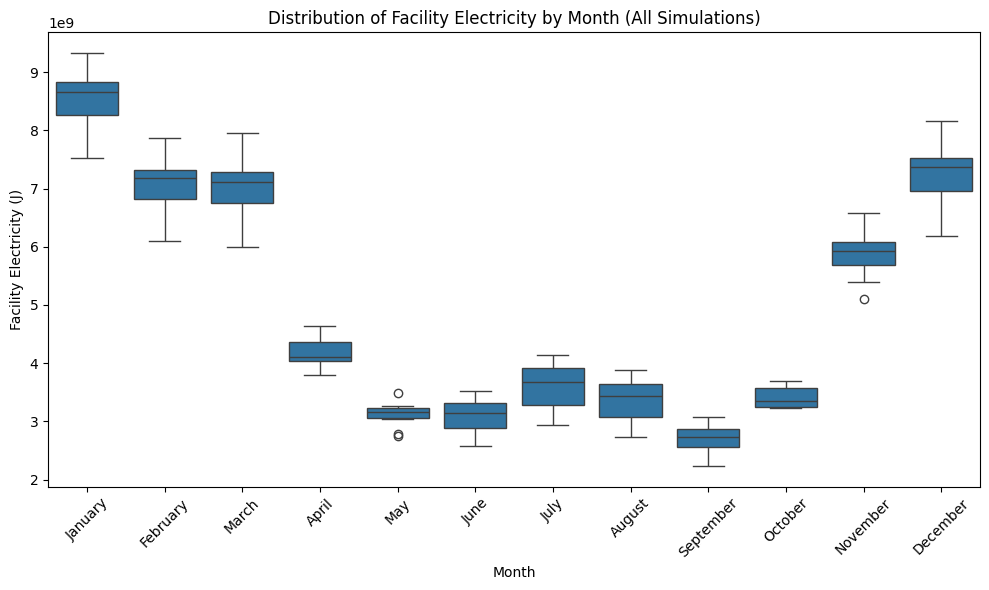

In [14]:
# Example path to your combined CSV file
csv_path = os.path.join(analysis_sim_dir, 'combined_sims.csv')

# Load the data
df = pd.read_csv(csv_path)

# -----------------------------------------------------------------------------
# 1) Box Plot - Distribution of Facility Electricity by Month Across Simulations
# -----------------------------------------------------------------------------

plt.figure(figsize=(10, 6))
sns.boxplot(x='Date/Time', y='Electricity:Facility [J](Monthly)', data=df)
plt.title('Distribution of Facility Electricity by Month (All Simulations)')
plt.xlabel('Month')
plt.ylabel('Facility Electricity (J)')
plt.xticks(rotation=45)  # Rotate month labels if needed
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

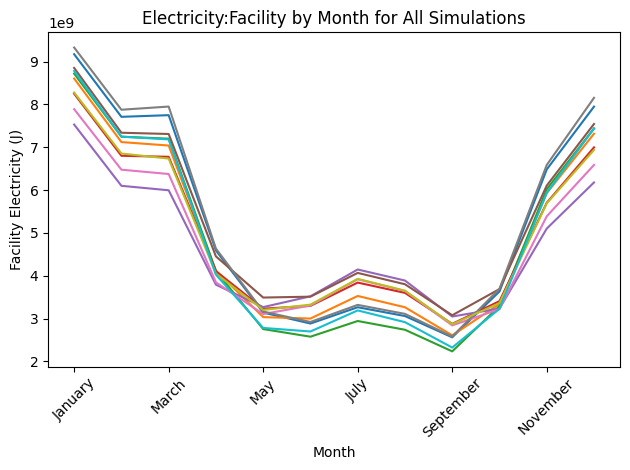

In [15]:
# -----------------------------------------------------------------------------
# 2) Line Plot - Each Simulation's Monthly Electricity Use
# -----------------------------------------------------------------------------
# This approach transforms the DataFrame into wide format, where each Simulation
# has a row, and each Month is a column. Then it plots all simulations as lines.

# Pivot so we have one row per Simulation_ID and one column per Month
# Define your month order
month_order = ["January", "February", "March", "April", "May", "June", 
               "July", "August", "September", "October", "November", "December"]

# Convert the Date/Time column to a Categorical with the specified order
df["Date/Time"] = pd.Categorical(
    df["Date/Time"], 
    categories=month_order, 
    ordered=True
)

# Now pivot again. The columns will appear in the custom order
pivoted = df.pivot_table(
    index='Simulation_ID',
    columns='Date/Time',
    values='Electricity:Facility [J](Monthly)'
)

# Plot
plt.figure(figsize=(10, 6))
pivoted.T.plot(legend=False)  # Transpose so Months go to the x-axis
plt.title('Electricity:Facility by Month for All Simulations')
plt.xlabel('Month')
plt.ylabel('Facility Electricity (J)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

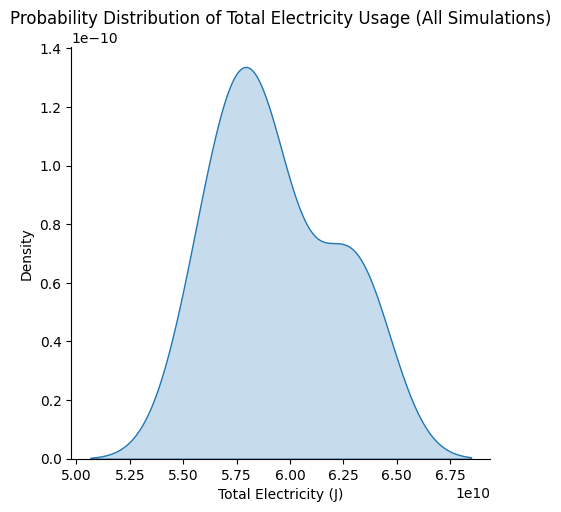

In [16]:
# Assume df has columns "Simulation_ID" and "Electricity:Facility [J](Monthly)"

# Sum the electricity usage for each simulation
df_summed = (
    df
    .groupby("Simulation_ID")["Electricity:Facility [J](Monthly)"]
    .sum()
    .reset_index(name="Total_Electricity")
)

# Plot the probability density of total electricity usage
sns.displot(data=df_summed, x="Total_Electricity", kind="kde", fill=True)
plt.title("Probability Distribution of Total Electricity Usage (All Simulations)")
plt.xlabel("Total Electricity (J)")
plt.ylabel("Density")
plt.show()